## To Do : 
### a. Random Forest Classifier
### b. Documenting Experience on Data Preprocessing

In [1]:
# Note: All the preprocessing step that we have carried out on train data would also be needed to carried out ...
#       ... on the test data. As a result we might have to later ensure that the way we are handling outlier ...
#       ...either through binning or imputation is constant for a given feature within both train and test set.
    

In [2]:
import pandas as pd
import os
import matplotlib
%matplotlib inline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import pickle


import warnings
warnings.filterwarnings("ignore")


In [3]:
# for dirname, _, filenames in os.walk('/mnt/'):
#     for filename in filenames:
#         print(os.path.join(dirname,filename))

In [4]:
train_data = pd.read_csv('/mnt/cs-training.csv')

In [5]:
train_data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
train_data_input = train_data.loc[:,~train_data.columns.isin(['Unnamed: 0','SeriousDlqin2yrs'])]

In [7]:
train_data_input.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
train_data_output = train_data[['SeriousDlqin2yrs']]

In [9]:
train_data_output.head()

,SeriousDlqin2yrs
0,1
1,0
2,0
3,0
4,0


In [10]:
train_data_input.shape

(150000, 10)

In [11]:
train_data_output.shape

(150000, 1)

In [12]:
# Listing all input features

for feature in train_data_input.columns:
    print(feature)

RevolvingUtilizationOfUnsecuredLines
age
NumberOfTime30-59DaysPastDueNotWorse
DebtRatio
MonthlyIncome
NumberOfOpenCreditLinesAndLoans
NumberOfTimes90DaysLate
NumberRealEstateLoansOrLines
NumberOfTime60-89DaysPastDueNotWorse
NumberOfDependents


# Data Exploration

## Exploring Output Data

In [13]:
output_stat = Counter(train_data_output.SeriousDlqin2yrs)

In [14]:
print("Percentage of Customers who default are: "+str(round(output_stat[1]*100/(output_stat[0]+output_stat[1]),2))+"%")

Percentage of Customers who default are: 6.68%


In [15]:
print("Percentage of Customers who do not default are: "+str(round(output_stat[0]*100/(output_stat[0]+output_stat[1]),2))+"%")


Percentage of Customers who do not default are: 93.32%


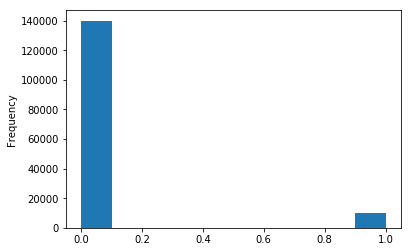

In [16]:
train_data_output['SeriousDlqin2yrs'].plot.hist()

In [17]:
#Note: the data above is an example of class imbalance having the ration of 7:93
## Generally there are two approaches to handle class imbalance:
## a. sampling based
## b. cost based 

# Lets read through this on Class imbalance: 
## https://machinelearningmastery.com/what-is-imbalanced-classification/
## https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23

## Exploring Input Features

### Seeing if any columns has Nan value

In [18]:
train_data_input.columns[train_data_input.isna().any()]

Index(['MonthlyIncome', 'NumberOfDependents'], dtype='object')

### Imputing missing data points for MonthlyIncome with KNN

In [19]:
# #Source: https://medium.com/@Cambridge_Spark/tutorial-introduction-to-missing-data-imputation-4912b51c34eb

# # n_neighbors = 3 (can be passed with the term n_neighbors), that is three neighbors to consider
# # weights = 'distance' means that the priority to neighbors will be inversely proportional to their distance
# knn_model = KNeighborsClassifier(3,weights='distance')

# # Dropping na's for the purpose of training the dataset
# complete_train_data_input = train_data_input.dropna()

# # X : all columns except for MonthlyIncome and NumberOfDependesnts as MonthlyIncome is Y for us and ... 
# #     ... NumberOFDependents itself will be undergoing missing data imputation by KNN
# # Y : MonthlyIncome
# knn_model.fit(complete_train_data_input.loc[:,~complete_train_data_input.columns.isin(['MonthlyIncome','NumberOfDependents'])],
#              complete_train_data_input['MonthlyIncome'])

# # Predict on all the rows where MonthlyIncome was null
# predicted_MonthlyIncome = knn_model.predict(
#     train_data_input.loc[:,~train_data_input.columns.isin(['MonthlyIncome','NumberOfDependents'])][train_data_input['MonthlyIncome'].isna()])

# # Fill in the null MonthlyIncome with the ones predicted using KNN
# train_data_input.loc[train_data_input['MonthlyIncome'].isna(),'MonthlyIncome'] = predicted_MonthlyIncome


In [20]:
train_data_input.columns[train_data_input.isna().any()]

Index(['MonthlyIncome', 'NumberOfDependents'], dtype='object')

### Imputing missing data points for NumberOfDependents with KNN

In [21]:
# # n_neighbors = 3
# knn = KNeighborsClassifier(3,weights='distance')

# # X : All non-nan rows of all columns except for MonthlyIncome and NumberOfDependents. NumberOfDependents ...
# #     ... would be Y and MonthlyIncome had been imputed with KNN and therefore it is not included here
# complete_dataset = train_data_input.loc[:,~train_data_input.columns.isin(['MonthlyIncome','NumberOfDependents'])][~train_data_input['NumberOfDependents'].isna()]

# # Fitting model on X and Y
# knn.fit(complete_dataset,train_data_input[~train_data_input['NumberOfDependents'].isna()]['NumberOfDependents'])

# # Predicting NumberOfDependents for the rows where tits value was missing
# NumberOfDependents_predicted = knn.predict(train_data_input.loc[:,~train_data_input.columns.isin(['MonthlyIncome',
#                                                                                                 'NumberOfDependents'])][train_data_input['NumberOfDependents'].isna()])
# # Imputing the null NumberOfDependents with the ones predicted using KNN
# train_data_input.loc[train_data_input['NumberOfDependents'].isna(),'NumberOfDependents'] = NumberOfDependents_predicted

In [22]:
train_data_input.columns[train_data_input.isna().any()]

Index(['MonthlyIncome', 'NumberOfDependents'], dtype='object')

### Outcome after imputing missing values of MonthlyIncome and NumberOfDependents using KNN


In [23]:
### We found that imputing NaN MonthlyIncome and NumberOfDependents feature using KNN approach the precision ...
### ... and recall drops compared to when they where just imputed with 0. So, we are currently not imputing them ...
### ... with the KNN approach.


### RevolvingUtilizationOfUnsecuredLines

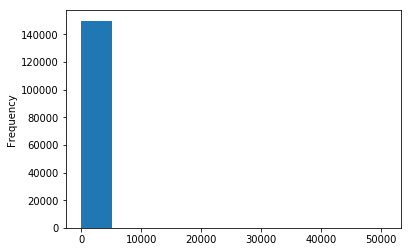

In [24]:
train_data_input['RevolvingUtilizationOfUnsecuredLines'].plot.hist()

In [25]:
train_data['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

#### Detecting whether RevolvingUtilizationOfUnsecuredLines has outliers

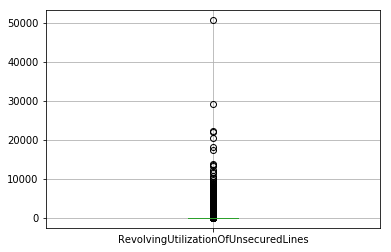

In [26]:
# Indentifying if ReveolvingUtilizationOfUnsecuredLines has any otliers
## Link on article about Outlier detection: https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

#Approach 1: Extreme Value Analysis
# https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07
## Interquartile range is given by, IQR = Q3 — Q1 
## Upper limit = Q3+1.5*IQR 
## Lower limit = Q1–1.5*IQR 
## Anything below the lower limit and above the upper limit is considered an outlier
## Note: Linear models are more impacted by the outliers than the tree based models. Source: https://www.quora.com/Why-are-tree-based-models-robust-to-outliers

train_data_input[['RevolvingUtilizationOfUnsecuredLines']].boxplot()

In [27]:
q_1 = train_data['RevolvingUtilizationOfUnsecuredLines'].describe()['25%']
q_3 = train_data['RevolvingUtilizationOfUnsecuredLines'].describe()['75%']
inter_quartile_range =  round(q_3 - q_1,2)
upper_limit_outlier = round(q_3 + 1.5*inter_quartile_range,2)
lower_limit_outlier = round(q_3 - 1.5*inter_quartile_range,2)

In [28]:
inter_quartile_range, lower_limit_outlier, upper_limit_outlier

(0.53, -0.24, 1.35)

In [29]:
outlier_count = 0
lower_outliers, upper_outliers = 0,0
for i in train_data_input['RevolvingUtilizationOfUnsecuredLines']:
    if i > upper_limit_outlier:
        upper_outliers+=1 
        outlier_count+=1
    if i < lower_limit_outlier:
        lower_outliers+=1
        outlier_count+=1


print("Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is "+str(outlier_count*100/len(train_data_input['RevolvingUtilizationOfUnsecuredLines']))+"%")


Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is 0.51%


In [30]:
print(upper_outliers,lower_outliers)

765 0


#### Handling outliers of RevolvingUtilizationOfUnsecuredLines

In [31]:
# How to deal with these outliers? Should they be removed, imputed, etc?
## Currently we are imputing the outliers with values, 
## upper_outliers will be imputed with the maximum value that falls under upper_limit_outlier
## lower_outliers will be imputed with the minimum value that falls under lower_limit_outlier

In [32]:
valid_upper_val = train_data_input[train_data_input['RevolvingUtilizationOfUnsecuredLines'] < upper_limit_outlier]['RevolvingUtilizationOfUnsecuredLines'].max()
valid_lower_val = train_data_input[train_data_input['RevolvingUtilizationOfUnsecuredLines'] > lower_limit_outlier]['RevolvingUtilizationOfUnsecuredLines'].min()



In [33]:
valid_upper_val,valid_lower_val

(1.349255721, 0.0)

In [34]:
train_data_input.loc[train_data_input['RevolvingUtilizationOfUnsecuredLines']>upper_limit_outlier,'RevolvingUtilizationOfUnsecuredLines']=valid_upper_val
train_data_input.loc[train_data_input['RevolvingUtilizationOfUnsecuredLines']<lower_limit_outlier,'RevolvingUtilizationOfUnsecuredLines']=valid_lower_val


In [35]:
#### Confirming that outliers of RevolvingUtilizationOfUnsecuredLines has been handled

In [36]:
outlier_count = 0
lower_outliers, upper_outliers = 0,0
for i in train_data_input['RevolvingUtilizationOfUnsecuredLines']:
    if i > upper_limit_outlier:
        upper_outliers+=1 
        outlier_count+=1
    if i < lower_limit_outlier:
        lower_outliers+=1
        outlier_count+=1


print(upper_outliers,lower_outliers,"Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is "+str(outlier_count*100/len(train_data_input['RevolvingUtilizationOfUnsecuredLines']))+"%")


0 0 Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is 0.0%


### age

In [37]:
train_data_input['age'].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

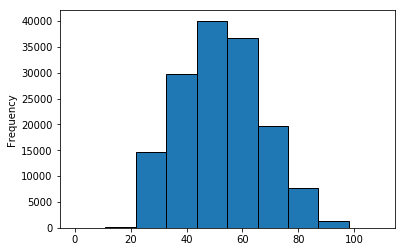

In [38]:
train_data_input['age'].plot.hist(edgecolor='black')

In [39]:
# options are: outlier, bin or adaptive_bin
age_bin_or_outlier = 'adaptive_bin'

#### Experimenting with Fixed Width Binning for age column
##### Note: While runing binning, do not run the outlier code of the age so that we are able to identify the affaect of the two independently

In [40]:
# Fixed with Binning: Source, https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b#:~:text=Binning%2C%20also%20known%20as%20quantization,are%20binned%20or%20grouped%20into.

if age_bin_or_outlier == 'bin':

    train_data_input['age_fixed_width_bin'] = np.where(train_data_input['age'] <= 25, 1,
                                            np.where(train_data_input['age'] <= 35, 2,
                                            np.where(train_data_input['age'] <= 45, 3,
                                            np.where(train_data_input['age'] <= 55, 4,
                                            np.where(train_data_input['age'] <= 65, 5,
                                            np.where(train_data_input['age'] <= 75, 6,
                                            np.where(train_data_input['age'] <= 85, 7,
                                            np.where(train_data_input['age'] <= 95, 8,9))))))))
    
    print(set(train_data_input['age_fixed_width_bin']))
    
    train_data_input['age'] = train_data_input['age_fixed_width_bin']
    
    train_data_input.drop(columns='age_fixed_width_bin',inplace=True)

#### Experimenting with Adaptive Binning for age column

##### Concept behind Adaptive Binning:     In Fixed-Width-Binning we manually create the threshold for the bins. In Adaptive based we look at distribution of the data to create the bins.

In [41]:
if age_bin_or_outlier == 'adaptive_bin':

    quantiles = 10 # Example: if quantiles = 4, it means, bins will be 0-25 percentile, 25-50th percentile, 50-75th percentile and 75-100th percentile
    quantile_label = [i for i in range(quantiles)]
    train_data_input['age_adaptive_bin'] = pd.qcut(train_data_input['age'],
                                                   q=quantiles,
                                                   labels=quantile_label)

    print(set(train_data_input['age_adaptive_bin']))

    train_data_input['age'] = train_data_input['age_adaptive_bin']

    train_data_input.drop(columns='age_adaptive_bin',inplace=True)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


#### Detecting outliers for age

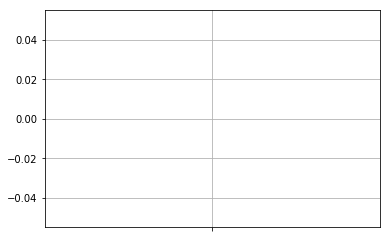

In [42]:
train_data_input[['age']].boxplot()

In [43]:
if age_bin_or_outlier == 'outlier':

    percent_75_age = train_data_input['age'].describe()['75%']
    percent_25_age = train_data_input['age'].describe()['25%']
    iqr = percent_75_age - percent_25_age
    valid_upper_range = percent_75_age + 1.5*iqr
    valid_lower_range = percent_25_age - 1.5*iqr

    print(valid_upper_range,valid_lower_range)

In [44]:
if age_bin_or_outlier == 'outlier':
    outlier_count = 0
    for age in train_data_input['age']:
        if age > valid_upper_range or age < valid_lower_range:
            outlier_count+=1

    print(outlier_count, "Percentage of outliers in age are "+str(round(outlier_count*100/train_data_input['age'].count(),2))+"%")

#### Handling outliers for age

In [45]:
if age_bin_or_outlier == 'outlier':
    max_valid_age = train_data_input[train_data_input['age']<valid_upper_range]['age'].max()
    min_valid_age = train_data_input[train_data_input['age']>valid_lower_range]['age'].min()
    print(max_valid_age,min_valid_age)

In [46]:
if age_bin_or_outlier == 'outlier':
    train_data_input.loc[train_data_input['age'] > valid_upper_range,'age']=max_valid_age
    train_data_input.loc[train_data_input['age'] < valid_lower_range,'age']=min_valid_age

### Exploring three relevant seeming PastDue features together

#### NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate


In [47]:
due_30_59 = 'NumberOfTime30-59DaysPastDueNotWorse'
due_60_89 = 'NumberOfTime60-89DaysPastDueNotWorse'
due_90 = 'NumberOfTimes90DaysLate'

option = due_30_59

In [48]:
train_data_input[option].describe()

count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

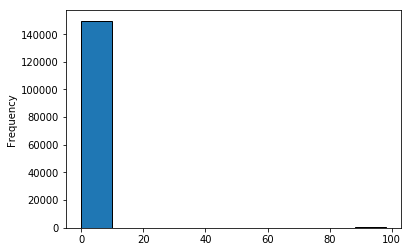

In [49]:
train_data_input[option].plot.hist(edgecolor='black')

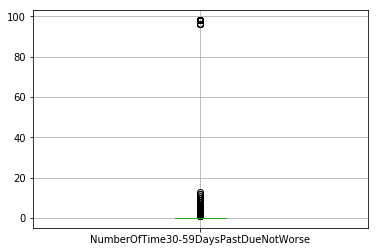

In [50]:
train_data_input[[option]].boxplot()

In [51]:
count=0
due_list = []
for due_frequency in train_data_input[option]:
    if due_frequency > 0:
        count+=1
        due_list.append(due_frequency)
        
print(sorted(Counter(due_list).items()))

[(1, 16033), (2, 4598), (3, 1754), (4, 747), (5, 342), (6, 140), (7, 54), (8, 25), (9, 12), (10, 4), (11, 1), (12, 2), (13, 1), (96, 5), (98, 264)]


#### Visualizing correlation among three features

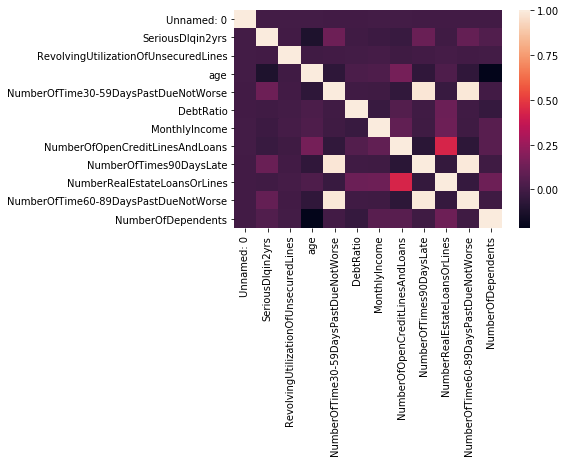

In [52]:
# Using Pearson corrleation:
# Source A : https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
# Source B :  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

correlated_matrix = train_data.corr()
sb.heatmap(correlated_matrix)

In [53]:
# Description of the above heatmap:
## a. Correlation values closer to 1 imply strong positive correlation. That is increase ... 
##    ... of value in one feature correspond to the increase of value in another feature and vice-versa.
## b. Correlation values closer to -1 imply strong negative correlation. That is increase ... 
##    ... of value in one feature correspond to the decrease of value in another feature and vice-versa.
## c. Correlation values closer to 0 imply weak correlation. Value of exact 0 implies no correlation at all.

## From the above heatmap we can see that the three below listed features are highly correlated:
## i. 'NumberOfTime30-59DaysPastDueNotWorse'
## ii. 'NumberOfTime60-89DaysPastDueNotWorse'
## iii. 'NumberOfTimes90DaysLate'

## And as we see below that their pairwise correlation is on the high end of 0.98 indicating ...
## very strong positive correlation


#### Two approach for the correlated features

In [54]:
## Approach 1: Retain only one feature and drop the other two
## In theory given that the three features are so highly correlated that they all might not be adding value ...
## ... so we can remove the other correlated features

## Lets say we maintain 'NumberOfTime30-59DaysPastDueNotWorse' and drop the other two:
# train_data_input.drop(columns=['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'],inplace=True)

## Doing so we see the Recall and Precision reduces significantly. The same is the case when we keep any one of ...
## ... the three and drop other two. Same happens if we keep any two and drop the other one.
## This shows that eventhough the features are highly correlated the model is finding all of them useful ...
## ... in making the predictions. Hence, we would not be able to drop any of the three feature


In [55]:
## Approach 2: Bin the dataset
## Given that three features have a very high positive correlation we can use the same concept and threshold of ...
## ... binning for all three features.

## For binning, we first analyze the dataset:
# print(sorted(Counter(train_data_input['NumberOfTime30-59DaysPastDueNotWorse']).items()))
## Given the other two features are related to this one, the Counter() for them also shows same trend to an extent
## From this data we relaize that majority do not have a PastDue scenario with majority of the occurences ...
## ... being 0. At same time I am thinking along the lines of 1 week, 2 weeks, 1 month and see if the ...
## ... customers are able to pay the due within that. This idea came around people getting a paycheck next ...
## ... week enabling them to pay the due or so on. Note, this a just a though process through which we defined ...
## ... bins and does not necessarily hold true. Nonetheless atleast we have a thought process behind determining ...
## ... these bins


one_day = 1
one_week = 7*one_day
half_month = 2*one_week
one_month = 4*one_week

custom_bins = {0:0,one_week:1,half_month:2, one_month:3}
## Due of 0 days, assign value 0
## Due of (0,7] days, assign value 1
## Due of (7,14] days, assign value 2
## Due of (14,28] days, assign value 3
## Due beyond 28 days, assign value 4
## The code in below cell is execusting the above logic
    
print(custom_bins)

{0: 0, 7: 1, 14: 2, 28: 3}


In [56]:
for past_due_feature in ['NumberOfTime60-89DaysPastDueNotWorse',
                         'NumberOfTimes90DaysLate',
                         'NumberOfTime30-59DaysPastDueNotWorse']:
    
    train_data_input[past_due_feature] = np.where(train_data_input[past_due_feature]>one_month,
                                                  custom_bins[one_month]+1, 
                                                  np.where(train_data_input[past_due_feature]>half_month,
                                                           custom_bins[half_month]+1, 
                                                           np.where(train_data_input[past_due_feature]>one_week, 
                                                                    custom_bins[one_week]+1, 
                                                                    np.where(train_data_input[past_due_feature]>0, 
                                                                             custom_bins[0]+1,0))))
    
    print(sorted(Counter(train_data_input[past_due_feature]).items()))


[(0, 142396), (1, 7331), (2, 4), (4, 269)]
[(0, 141662), (1, 8005), (2, 61), (3, 3), (4, 269)]
[(0, 126018), (1, 23668), (2, 45), (4, 269)]


### DebtRatio	


#### Analyzing and Visualizing DebtRatio

In [57]:
train_data_input['DebtRatio'].describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

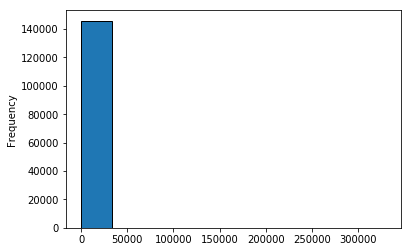

In [58]:
train_data_input[train_data_input['DebtRatio']>0]['DebtRatio'].plot.hist(edgecolor='Black')

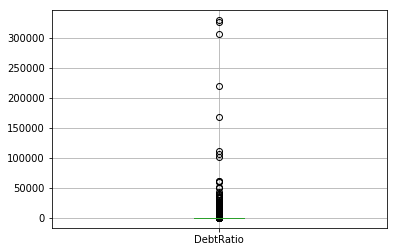

In [59]:
train_data_input[['DebtRatio']].boxplot()

#### Thoughts after Visual Analysis of DebtRatio feature

In [60]:
## The data is scattered out ranging from 0% to as high as 32,966,400% debt utilization. Thus we can ... 
## ... use three approach:
## 1. Make customize bin and do data binning
## 2. Do Extreme Value Analysis and impute outliers with the highest/lowest value respectively
## 3. Explore Normalization or standardization of the feature


## Note : DebtRatio is present as ratio to multiply it by 100 to convert to percentage.

In [61]:
# #Approach 1: Making custom bins for the DebtRatio

# #DebtRatio bins in percentage format
# # 0: [0]
# # 1: (0,20%]
# # 2: (20,40%]
# # 3: (40,60%]
# # 4: (60,80%]
# # 5: (80,100%]
# # 6: (100%,200%]
# # 7: (200%,500%]
# # 8: (500%,]

 
# train_data_input['DebtRatio'] = np.where(train_data_input['DebtRatio'] > 5, 8,
#                                         np.where(train_data_input['DebtRatio'] > 2, 7,
#                                                 np.where(train_data_input['DebtRatio'] > 1, 6,
#                                                         np.where(train_data_input['DebtRatio'] > .8, 5,
#                                                                 np.where(train_data_input['DebtRatio'] > .6, 4,
#                                                                         np.where(train_data_input['DebtRatio'] > .4, 3,
#                                                                                 np.where(train_data_input['DebtRatio'] > .2, 2,
#                                                                                         np.where(train_data_input['DebtRatio'] > 0, 1, 0))))))))



In [62]:
# Approach 2: Do Extreme Value Analysis and impute outliers with the highest/lowest value respectively

q1 = train_data_input['DebtRatio'].describe()['25%']
q3 = train_data_input['DebtRatio'].describe()['75%']
iqr = q3-q1

outlier_upper_range = round(q3 + 1.5*iqr,2)
outlier_lower_range = round(q1 - 1.5*iqr,2)


non_outlier_highest_value = round(train_data_input[train_data_input['DebtRatio']<outlier_upper_range]['DebtRatio'].max(),2)
non_outlier_lowest_value = round(train_data_input[train_data_input['DebtRatio']>outlier_lower_range]['DebtRatio'].min(),2)

print(outlier_upper_range,outlier_lower_range,non_outlier_highest_value,non_outlier_lowest_value)

train_data_input.loc[train_data_input['DebtRatio']>outlier_upper_range,'DebtRatio'] = non_outlier_highest_value
train_data_input.loc[train_data_input['DebtRatio']<outlier_lower_range,'DebtRatio'] = non_outlier_lowest_value

1.91 -0.86 1.91 0.0


In [63]:
# # Approach 3: Exploring Normalization or standardization of the feature
# # Note: ML algorithms using Gradient Descent as an optimization technique are sensitive to ...
# #       ... feature scaling. Take a look at the formula on why this is the case at the source ...
# #       ... link below. Feature scaling atleast seem to help gradient descent converge faster ...
# #       ... but I am not yet sure if it helps improve the performance on recall/precision or ...
# #       ... other accuracy metrics.
# #
# #       Distance based algorithms are also affected by it.Whereas Tree based algorithms ...
# #       ... are insensitive to different feautres being on different scale as they split ...
# #       ... a node on a single feature. This makes Tree based algorithms invariant to ...
# #       ... feature scaling.
# #
# # Source: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

# # Normalization:
# # Scale a feature from 0 to 1. Minimum value becomes 0 and maximum value becomes 1. It is also ...
# # ... called as Min-Max scaling.
# # new_value = (original_value - min_value)/(max_value - min_vale)

# # Standardization:
# # Values are centered around min with unit standard deviation. That is, the mean becomes 0 and the ...
# # ... resultant distribution has unit standard deviation. Unlike normalization, the values are not ...
# # ... restricted to a specifc range.
# # new_value = (original_value - mean)/(Standard Deviation)

# # Note: It seems that if the data has ourliers on either ends than the Normalization range of 0-1 would be ...
# #       ... affected by it. Because in that case 1 will be the outlier on maximum range and/or 0 will be ...
# #       ... the outlier on the minimum range. 

# # sklearn Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# # sklearn Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# normalize_or_standardize = 'standardize'

# # If we want to Normalize
# if normalize_or_standardize == 'normalize':
#     scaler = MinMaxScaler(feature_range=(0,1))

# # If we want to standardize 
# if normalize_or_standardize == 'standardize':
#     scaler = StandardScaler()
    
# train_data_input['DebtRatio'] = scaler.fit_transform(train_data_input[['DebtRatio']])
# train_data_input['DebtRatio'].describe()


### MonthlyIncome

#### Visualizing distribution of MonthlyIncome

In [64]:
train_data_input['MonthlyIncome'].describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

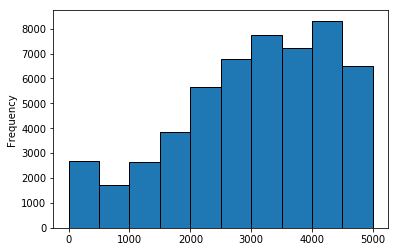

In [65]:
train_data_input[train_data_input['MonthlyIncome']<5000]['MonthlyIncome'].plot.hist(edgecolor = 'Black')

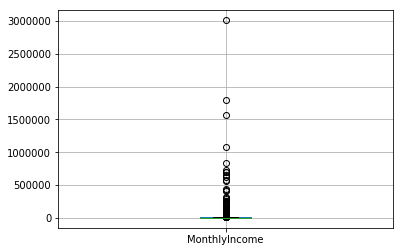

In [66]:
train_data_input[['MonthlyIncome']].boxplot()

#### Handling Extreme Values/Outliers

In [67]:
# # Approach 1: Adaptive Bin based approach, divide data into four bins based on percentile; 
# #             0-25%, 25%-50%, 50%-75% and 75%-100%

# total_bins = 4
# train_data_input['MonthlyIncome'] = pd.qcut(train_data_input['MonthlyIncome'],
#                                             q=total_bins, 
#                                             labels=[i+1 for i in range(total_bins)])

# train_data_input['MonthlyIncome'].describe()

In [68]:
# # Approach 2: Do Extreme Value Analysis and impute outliers with the highest/lowest value respectively

# q1 = train_data_input['MonthlyIncome'].describe()['25%']
# q3 = train_data_input['MonthlyIncome'].describe()['75%']
# iqr = round(q3 - q1,2)

# upper_outlier_data = q3 + 1.5*iqr
# lower_outlier_data = q1 - 1.5*iqr

# upper_valid_data = train_data_input[train_data_input['MonthlyIncome'] < upper_outlier_data]['MonthlyIncome'].max()
# lower_valid_data = train_data_input[train_data_input['MonthlyIncome'] > lower_outlier_data]['MonthlyIncome'].min()

# train_data_input.loc[train_data_input['MonthlyIncome'] > upper_outlier_data,'MonthlyIncome']=upper_valid_data
# train_data_input.loc[train_data_input['MonthlyIncome'] < lower_outlier_data,'MonthlyIncome']=lower_valid_data

# train_data_input['MonthlyIncome'].describe()

#### Note for MonthlyIncome

In [69]:
# Using either Approach 1 or 2, we found that the performance of the Logistic Model decreased. As a result ...
# ... of it we are keeping the feature as it is without making any changes to it.

### NumberOfOpenCreditLinesAndLoans

#### Visualizing distribution of NumberOfOpenCreditLinesAndLoans

In [70]:
train_data_input['NumberOfOpenCreditLinesAndLoans'].describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

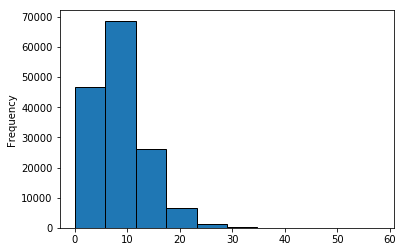

In [71]:
train_data_input['NumberOfOpenCreditLinesAndLoans'].plot.hist(edgecolor='Black')

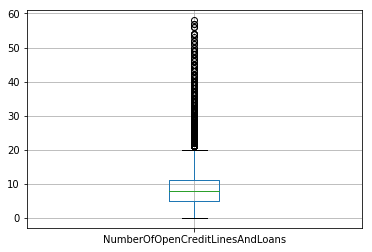

In [72]:
train_data_input[['NumberOfOpenCreditLinesAndLoans']].boxplot()

#### Binning of NumberOfOpenCreditLinesAndLoans feature

In [73]:
# number_of_bins = 4

# train_data_input['NumberOfOpenCreditLinesAndLoans'] = pd.qcut(train_data_input['NumberOfOpenCreditLinesAndLoans'],
#                                                              q = number_of_bins,
#                                                              labels = [i for i in range(number_of_bins)])

# train_data_input['NumberOfOpenCreditLinesAndLoans'].describe()

#### Imputing of NumberOfOpenCreditLinesAndLoans feature

In [74]:
# q1 = round(train_data_input['NumberOfOpenCreditLinesAndLoans'].describe()['25%'],2)
# q3 = round(train_data_input['NumberOfOpenCreditLinesAndLoans'].describe()['75%'],2)
# iqr = q3-q1

# valid_upper_range = q3 + 1.5*iqr
# valid_lower_range = q1 - 1.5*iqr

# print(q1,q3,iqr,valid_upper_range,valid_lower_range)

# valid_upper_val = train_data_input[train_data_input['NumberOfOpenCreditLinesAndLoans'] < valid_upper_range]['NumberOfOpenCreditLinesAndLoans'].max()
# valid_lower_val = train_data_input[train_data_input['NumberOfOpenCreditLinesAndLoans'] > valid_lower_range]['NumberOfOpenCreditLinesAndLoans'].min()

# print(valid_upper_val,valid_lower_val)

# train_data_input.loc[train_data_input['NumberOfOpenCreditLinesAndLoans'] > valid_upper_val,'NumberOfOpenCreditLinesAndLoans'] = valid_upper_val
# train_data_input.loc[train_data_input['NumberOfOpenCreditLinesAndLoans'] < valid_lower_val,'NumberOfOpenCreditLinesAndLoans'] = valid_lower_val

# print(train_data_input['NumberOfOpenCreditLinesAndLoans'].describe())

#### Note for NumberOfOpenCreditLinesAndLoans feature

In [75]:
# Using either Approach of Binning or Imputation, we found that the performance of the Logistic Model decreased ...
# ... (only Recall increased by 1% in Imputataion approach). As a result of it we are keeping the feature as it is ...
# ... without making any changes to it.

### NumberRealEstateLoansOrLines	

#### Visually analyzing NumberRealEstateLoansOrLines feature

In [76]:
train_data_input['NumberRealEstateLoansOrLines'].describe()

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

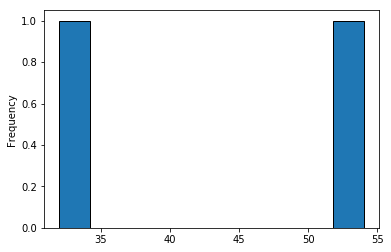

In [77]:
train_data_input[train_data_input['NumberRealEstateLoansOrLines']>30]['NumberRealEstateLoansOrLines'].plot.hist(edgecolor='Black')


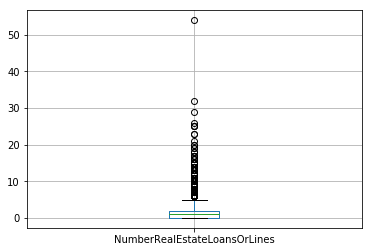

In [78]:
train_data_input[['NumberRealEstateLoansOrLines']].boxplot()

#### Binning outliers of NumberRealEstateLoansOrLines feature

In [79]:
# # qcut based approach is not great for the distribution that NumberRealEstateLoansOrLines has.
# # Its min value is 25% both zero, this cuases duplicates in bin range if we use a quratile (i.e. 4 quantiles)
# # based approach. We can reduce the number of bins and use the `duplicates='drop'` setting but still it does
# # not seem to be a great alternative. So we will try setting custom bins

# bins = 2
# train_data_input['NumberRealEstateLoansOrLines'] = pd.qcut(train_data_input['NumberRealEstateLoansOrLines'],
#                                                           q = bins,
#                                                           labels = [i for i in range(bins)],
#                                                           duplicates = 'drop')

In [80]:
# # Custom binning
# # 0 : 0
# # (0,1]: 1
# # (1,2] : 2
# # (2,5] : 3
# # (5,10] : 4
# # (10,20] : 5
# # (20,30] : 6
# # (30,] : 7

# var_name = 'NumberRealEstateLoansOrLines'
# train_data_input[var_name] = np.where(train_data_input[var_name] > 30, 7,
#                                      np.where(train_data_input[var_name] > 20, 6,
#                                              np.where(train_data_input[var_name] > 10, 5,
#                                                      np.where(train_data_input[var_name] > 5, 4,
#                                                              np.where(train_data_input[var_name] > 2, 3,
#                                                                      np.where(train_data_input[var_name] > 1, 2,
#                                                                              np.where(train_data_input[var_name] > 0, 1, 0)))))))

# train_data_input[var_name].describe()

#### Imputing outliers of NumberRealEstateLoansOrLines feature

In [81]:
# q1 = round(train_data_input['NumberRealEstateLoansOrLines'].describe()['25%'],2)
# q3 = round(train_data_input['NumberRealEstateLoansOrLines'].describe()['75%'],2)

# iqr = q3-q1

# valid_upper_val = q3 + 1.5*iqr
# valid_lower_val = q1 - 1.5*iqr

# max_upper_val = train_data_input[train_data_input['NumberRealEstateLoansOrLines'] < valid_upper_val]['NumberRealEstateLoansOrLines'].max()
# min_lower_val = train_data_input[train_data_input['NumberRealEstateLoansOrLines'] > valid_lower_val]['NumberRealEstateLoansOrLines'].min()

# train_data_input.loc[train_data_input['NumberRealEstateLoansOrLines'] > max_upper_val,'NumberRealEstateLoansOrLines'] = max_upper_val
# train_data_input.loc[train_data_input['NumberRealEstateLoansOrLines'] < min_lower_val,'NumberRealEstateLoansOrLines'] = min_lower_val

# train_data_input['NumberRealEstateLoansOrLines'].describe()

#### Note for NumberRealEstateLoansOrLines feature

In [82]:
# Using either Approach of Binning or Imputation, we found that the performance of the Logistic Model decreased. ...
# ... As a result of it we are keeping the feature of NumberRealEstateLoansOrLines as it is without making any ...
# ... changes to it.

### NumberOfDependents

In [83]:
train_data_input['NumberOfDependents'].describe()

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

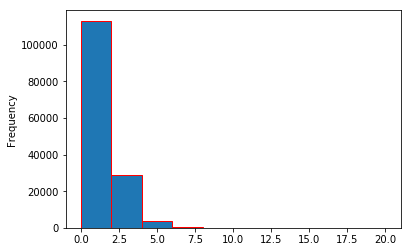

In [84]:
train_data_input['NumberOfDependents'].plot.hist(edgecolor='red')

In [85]:
sorted(train_data_input['NumberOfDependents'].unique())

[0.0, 1.0, 2.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 13.0, 20.0]

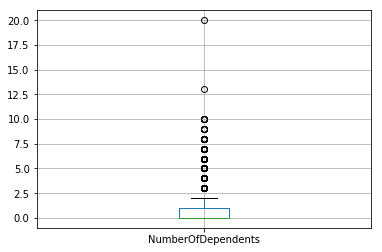

In [86]:
train_data_input[['NumberOfDependents']].boxplot()

#### Approach 1: Binning outliers of NumberOfDependents

In [87]:
# # Customized Bins
# #0 : 0
# # (0,1] : 1
# # (1,2] : 2
# # (2,3] : 3
# # (3,4] : 4
# # (4,5] : 5
# # (5,10] : 6
# # (10,20]: 7
# # (20,] : 8


# train_data_input['NumberOfDependents'] = np.where(train_data_input['NumberOfDependents']>20,8,
#                                                  np.where(train_data_input['NumberOfDependents']>10,7,
#                                                          np.where(train_data_input['NumberOfDependents']>5,6,
#                                                                  np.where(train_data_input['NumberOfDependents']>4,5,
#                                                                          np.where(train_data_input['NumberOfDependents']>3,4,
#                                                                                  np.where(train_data_input['NumberOfDependents']>2,3,
#                                                                                          np.where(train_data_input['NumberOfDependents']>1,2,
#                                                                                                  np.where(train_data_input['NumberOfDependents']>0,1,0))))))))


# train_data_input['NumberOfDependents'].describe()

#### Approach 2: Impute outliers of NumberOfDependents

In [88]:
# q1 = round(train_data_input['NumberOfDependents'].describe()['25%'],2)
# q3 = round(train_data_input['NumberOfDependents'].describe()['75%'],2)

# iqr = q3 - q1

# max_upper_val = q3 + 1.5*iqr
# min_lower_val = q1 - 1.5*iqr

# valid_upper_val = train_data_input[train_data_input['NumberOfDependents'] < max_upper_val]['NumberOfDependents'].max()
# valid_lower_val = train_data_input[train_data_input['NumberOfDependents'] > min_lower_val]['NumberOfDependents'].min()

# train_data_input.loc[train_data_input['NumberOfDependents'] > valid_upper_val, 'NumberOfDependents'] = valid_upper_val
# train_data_input.loc[train_data_input['NumberOfDependents'] < valid_lower_val, 'NumberOfDependents'] = valid_lower_val

# train_data_input['NumberOfDependents'].describe()

#### Note for NumberOfDependents feature

In [89]:

# Using either Approach of Binning or Imputation, we found that the performance of the Logistic Model decreased. ...
# ... As a result of it we are keeping the feature of NumberOfDependents as it is without making any ...
# ... changes to it.

## Documenting Experience on Data Preprocessing

In [90]:
## What we Did (correlation checking, outiler handling (binning, imputataion)), 
## What we did not (removing outliers, sampling, think more here ...)
## What we could not (handling missing data as the dataset had no missing data, think more here ...)

## Build Logistic Regression Model

In [91]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report

# # Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.htmlp

# # C : smaller values means strong regularization, default = 1
# # C = 2 increases precision but decreases recall


# # class_weight : it defines the penalty for miscalssyfing a given class, but default it is None, that is ...
# #                ... all the class have equal weight. Alternativesly we can pass the a dictionary of weights ...
# #                ... in argument. 
# # To caculate class_weight use following formula:
# # weight_for_class_j = total_number_of_samples / (total_classes) * (number_of_smaples_for_class_j)
# # Source: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# #
# # Note: if you state class_weight = 'balanced' then it will use the above formula to calculate class weight. ...
# #       ... Otherwise, we can figure out using below:

# calculated_class_weight = {}
# total_classes = train_data_output['SeriousDlqin2yrs'].unique() 
# for class_ in total_classes:
#     calculated_class_weight[class_] = round(len(train_data_output) / (len(total_classes)*
#                                                                len(train_data_output
#                                                                    [train_data_output['SeriousDlqin2yrs']==class_])),2)

# # intercept_scaling : smaller values mean higher impact of regualarization on synthetic feature weight
# # Not sure what exactly it does. Also, not sure if it is related to C which also is used for handling regularization.
# # intercept_scaling_val = 4/1000
# # Increasing its value higher than the default value of 1 does not have any impact on precision or recall. ...
# # ... Decreasing its value down from 1, increases Recall and decreases Precision


# # solver: For discussion on what solver to use for logistic regression look at below two resources:
# # Source 1: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
# # Source 2: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions/52388406#52388406

# model = LogisticRegression(class_weight = calculated_class_weight)

    
    

## Build Random Forest Classifier Model

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

number_of_features = len(train_data_input.columns)
model = RandomForestClassifier(n_estimators=10*number_of_features)

# n_estimators = range(number_of_features,10*number_of_features,number_of_features)
# param_grid = {'n_estimators':n_estimators}

# kfold = StratifiedKFold(n_splits=5)
# gridsearch = GridSearchCV(model,param_grid,cv=kfold)



In [93]:
# train_data_input.fillna(value=0,inplace=True) was throwing `ValueError: fill value must be in categories`
# What it means is that 0 is not already present in the columns having null values, this can be because the column 
# can be of different data type eg. string, float or so 

# We can overcome this error in two ways:
# Approach 1. Add np.nan as a category in the columns: Source (https://stackoverflow.com/questions/53664948/pandas-fillna-throws-valueerror-fill-value-must-be-in-categories)
# for column_having_nan_value in train_data_input.columns[train_data_input.isna().any()]:
#     print(type(column_having_nan_value))
#     train_data_input[column_having_nan_value] = train_data_input[column_having_nan_value].astype('category').cat.add_categories(0)
#     train_data_input[column_having_nan_value].fillna(0,inplace=True)
# Finding columns with nan values: Source (https://datatofish.com/columns-nan-pandas-dataframe/)
# But the approach 1 did not worked because of categories related error

#Approach 2: Use replace instead of fillna
train_data_input.replace(np.nan,0,inplace=True)




In [ ]:
model.fit(train_data_input,train_data_output)


In [ ]:
file_name = 'RandomForestMLModel.sav'
pickle.dump(model,open(file_name,'wb'))

# Source: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
# Source: https://stackoverflow.com/questions/40982132/python-pickle-dump-wb-parameter#:~:text=It%20means%3A%20open%20for%20writing%20and%20open%20in%20binary%20mode.&text='wb'%20means%20'write%20binary,file%20handle%3A%20open('save.

In [ ]:
predicted_output = model.predict(train_data_input)

In [ ]:
# Source: https://machinelearningmastery.com/calculate-feature-importance-with-python/
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# If Model is LogisticRegression
# feature_importances = model.coef_[0]

# If Model is RandomForestClassifier
feature_importances = model.feature_importances_

feature_names = train_data_input.columns

for counter, feature_importance in enumerate(feature_importances):
    print(feature_names[counter],'\n',round(feature_importance,2),'\n')


In [ ]:
# Source: https://stackoverflow.com/questions/40575067/matplotlib-bar-chart-space-out-bars/40575741
matplotlib.pyplot.figure(figsize=(20,10))
matplotlib.pyplot.bar([feature[:17] for feature in feature_names],feature_importances)
matplotlib.pyplot.show()

In [ ]:
print(classification_report(train_data_output['SeriousDlqin2yrs'],predicted_output))

In [ ]:
auc_score = round(sklearn.metrics.roc_auc_score(train_data_output['SeriousDlqin2yrs'],predicted_output),2)
print(auc_score)

# fpr, tpr, thresholds = sklearn.metrics.roc_curve(train_data_output['SeriousDlqin2yrs'],predicted_output,pos_label=1)
# print(sklearn.metrics.auc(fpr,tpr))
# # Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

##### [v1] Vanilla Logistic Regression has a Recall of 4% and a Precision of 55%. This will be our benchmark. 

##### [v2] After imputing outliers of `RevolvingUtilizationOfUnsecuredLines`, Recall increased to 5% (v.s. 4%) and Precision to 59% (v.s. 55%) for vanilla Logistic Regression.


##### [v3] After imputing outliers for `age`, Recall increased to 6% (v.s. 5%) but Precision stayed at 59% compared to previous update.


##### [v4] If we bin `age` through fixed width binning instead of doing outliers. The performance remains same as v2.

##### [v5] Adaptive Binning for `age` feature: Making a quartile based binning (i.e. 4 quantiles) the performance is same as v3. But making  it a decile based (i.e. 10 quantiles) the Recall stays at 6% but the Precision improves to 60% (v.s. 59%) compared to v3.

##### [v6] We found that the three features `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse`, `NumberOfTimes90DaysLate` are highly correlated. So we dropped other two and kept just one. This results in Precision falling to 55% (v.s. 60%) and Recall falling to 1% (v.s. 6%) compared to v5


##### [v7] If we bin three correlated features of `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse` and `NumberOfTimes90DaysLate`,  Recall increases to 13% (v.s. 6%) and Precision stays at 60% compared to v5


##### [v8] For `DebtRatio` feature, binning it drops to Recall to 12% (v.s. 13%) and maintains Precision at 60% compared to v7 

##### [v9] Instead of binning if we impute the Outliers or Extreme Values of `DebtRatio` feature then the Precision stays at 60% but Recall increases to 14% (v.s. 13%) compared to v7

##### [v10] On applying Standardization or Normalization on `DebtRatio` feature the Precision and Recall fall by a point reaching 59% (58% under Normalization) and 13% respectively  compared to v9

##### [v11] On Binning `MonthlyIncome` data we found that the Recall stays at 14% but Precision drops to 59% (v.s. 60%) compared to v9.

##### [v12] Imputing `MonthlyIncome` outliers result in Recall dropping to 13% (v.s. 14%) and Precision drops to 59% (v.s. 60%) compared to v9.

##### [v13] Binning `NumberOfOpenCreditLinesAndLoans`  Recall drops to 11% (v.s. 14%) and Precision drops to 55% (v.s. 60%) compared to v9.


##### [v14] Imputing `NumberOfOpenCreditLinesAndLoans` outliers result in Recall dropping to 11% (v.s. 14%) and Precision increasing to 61% (v.s. 60%) compared to v9.


##### [v15] Custom Binning of `NumberRealEstateLoansOrLines` results in Precision dropping to 57% (v.s. 60%) and Recall dropping to 13% (v.s. 14%) compared to v9.



##### [v16] Imputing outliers of `NumberRealEstateLoansOrLines` results in Precision dropping to 56% (v.s. 60%) and Recall dropping to 13% (v.s. 14%) compared to v9.



#### [v17] On Binning the outliers of `NumberOfDependents` the Recall drops to 12% (v.s. 14%) and Precision drops to 57% (v.s. 60%) compared to v9

#### [v18] On imputing the outliers of `NumberOfDependents` the Recall drops to 13% (v.s. 14%) and Precision remains at 60% compared to v9


#### [v19] On filling Nan in `MonthlyIncome` through KNN (k=3) instead of value 0 the Recall drops to 13% (v.s. 14%) and Precision remains at 60% compared to v9


#### [v20] On filling Nan in `NumberOfDependents` through KNN (k=3) instead of value 0 the Recall drops to 12% (v.s. 14%) and Precision drops to 57% (v.s. 60%) compared to v9


#### [v21] Parameter Tuning: On changing the `class_weight` attribute to 'balanced' instead of default the recall jumped to 74% (v.s. 14%) and Precision dropped to 22% (v.s. 60%) compared to v9

#### [v22] Implementing basic `RandomForestClassifier` increases Recall to 84% (v.s. 74%) and Precision to 99% (v.s. 22%) compared to v21



#### [v23] Using v22's `RandomForestClassifier` results in a AUC of 0.76899 on Test Dataset



#### [v24] Using `n_estimators=10*number_of_features` in `RandomForestClassifier` results in a AUC of 0.83158 on Test Dataset

